In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Pandas display options to show all columns and all rows if necessary. Puts a lot of strain of processor

In [2]:
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
pd.options.display.float_format= '{:.2f}'.format

In [3]:
nyse = pd.read_csv(os.path.join('Resources', 'nyse.csv'))
nasdaq = pd.read_csv(os.path.join('Resources', 'nasdaq.csv'))
amex = pd.read_csv(os.path.join('Resources', 'amex.csv'))

In [4]:
frames = [nyse, nasdaq, amex]
tickers = pd.concat(frames).sort_values(by='Ticker')

In [34]:
data_2018 = pd.read_csv(os.path.join('Resources', '2018_Financial_Data.csv')).\
rename(columns={'Unnamed: 0':'Ticker'}).\
sort_values(by='Ticker').\
reset_index(drop=True)

df = tickers.merge(data_2018, on='Ticker')

Note: In *__data_2018__* we had 4392 observations. When we merged with our *__tickers__* dataframe which had 8000+ tickers and company names from exchanges we lost 150 observations. These can be retrieved with 
``` 
data_2018[~data_2018.Ticker.isin(tickers['Ticker'])]
```
Here the **~** symbol essentially means NOT IN when we filter

## Conditional Filtering

In [ ]:
tickers[tickers['Company Name'].str.contains('Bond') == True];

In [ ]:
df[df['Company Name'].str.contains('Bond') == True];

In [ ]:
df[df['Ticker'].str.startswith('X') == True];

In [ ]:
df[df['Sector'] == "Consumer Cyclical"];

In [ ]:
df.head()

## Graphs and Visualizations

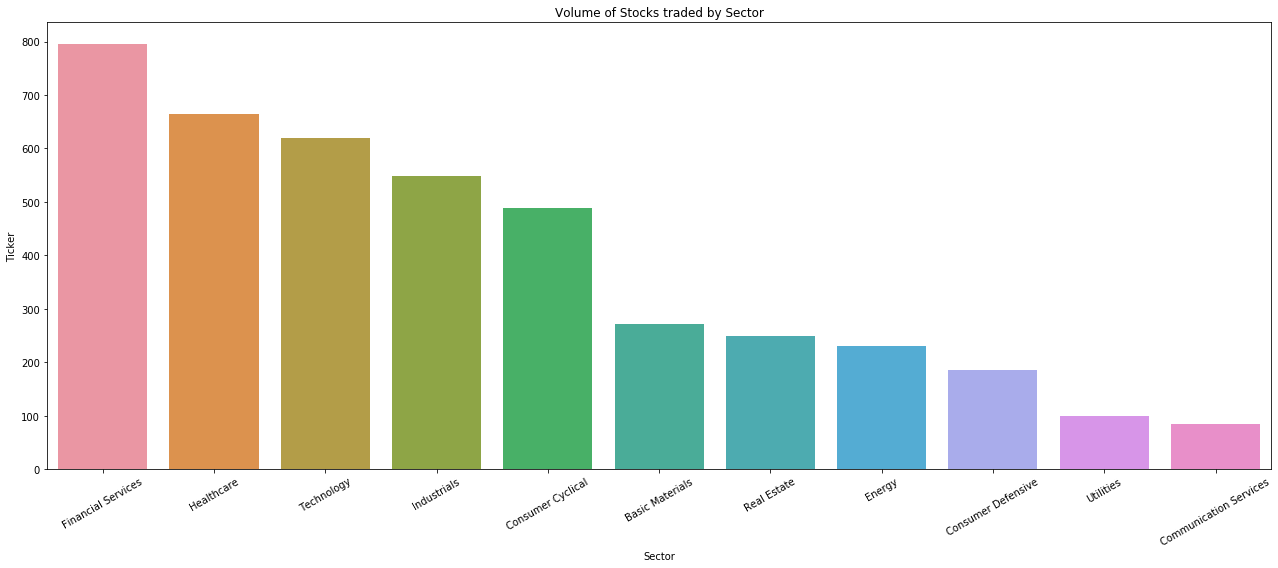

In [35]:
sector_count = pd.DataFrame(df.groupby(['Sector']).count()['Ticker']).reset_index().sort_values(by='Ticker', ascending=False)

plt.figure(figsize=(18,8))
plt.title('Volume of Stocks traded by Sector')
sns.barplot(x = sector_count['Sector'], y = sector_count['Ticker']).set_xticklabels(labels = sector_count['Sector'], rotation=30)
plt.tight_layout()
# plt.savefig(os.path.join('Figures','StockVolume_Sector.png'))

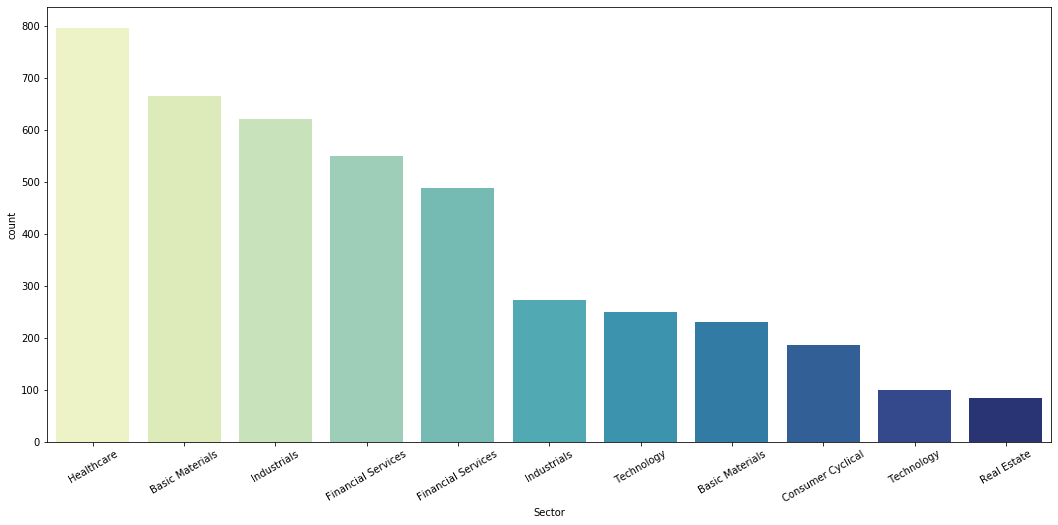

In [63]:
plt.figure(figsize=(18,8))
sns.countplot(x='Sector', data = df, palette='YlGnBu', order=df['Sector'].value_counts().index).set_xticklabels(labels = df['Sector'], rotation=30)
plt.savefig(os.path.join('Figures','StockVolume_Sector.png'))

In [ ]:
# df.to_csv(os.path.join('2018_data.csv'))